PRUEBA APPL - LSTM

Ptyhon Packages

In [ ]:
!pip install yfinance
!pip install deltalake
!pip install scikit-learn
!pip install tensorflow
!pip install matplotlib

import pandas as pd
import numpy as np
import yfinance as yf
import os
from deltalake import DeltaTable
from deltalake.writer import write_deltalake
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.6 MB/s eta 0:00:00


Load from Yahoo Finance and Save to DeltaLake

In [ ]:
def load_financial_data(ticker):
    """
    Load financial data for a given ticker.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        pd.DataFrame: DataFrame containing financial data.
    """
    DELTA_OUTPUT_PATH = f"./data/{ticker}_yfinance"
    # Fetch data from Yahoo Finance
    df = yf.download(ticker, start="2020-01-01", end="2025-06-30")
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")

    os.makedirs(DELTA_OUTPUT_PATH, exist_ok=True)
    write_deltalake(DELTA_OUTPUT_PATH, df, mode="overwrite")

    print(f"✅ Exported {len(df)} rows to {DELTA_OUTPUT_PATH}")

In [ ]:
df = yf.download('AAPL', start="2020-01-01", end="2025-06-30")

/tmp/ipython-input-10-1158009377.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start="2020-01-01", end="2025-06-30")
[*********************100%***********************]  1 of 1 completed


In [ ]:
df.droplevel('Ticker', axis=1)

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.620834,72.681281,71.373211,71.627084,135480400
2020-01-03,71.914803,72.676431,71.689942,71.847102,146322800
2020-01-06,72.487862,72.526549,70.783263,71.034724,118387200
2020-01-07,72.146927,72.753808,71.926900,72.497514,108872000
2020-01-08,73.307518,73.609752,71.849540,71.849540,132079200
...,...,...,...,...,...
2025-06-23,201.500000,202.300003,198.960007,201.630005,55814300
2025-06-24,200.300003,203.440002,200.199997,202.589996,54064000
2025-06-25,201.559998,203.669998,200.619995,201.449997,39525700


In [ ]:
df = df.droplevel(1,axis=1)

In [ ]:
df['ticker'] = 'AAPL'

In [ ]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620834,72.681281,71.373211,71.627084,135480400
2020-01-03,71.914803,72.676431,71.689942,71.847102,146322800
2020-01-06,72.487862,72.526549,70.783263,71.034724,118387200
2020-01-07,72.146927,72.753808,71.926900,72.497514,108872000
2020-01-08,73.307518,73.609752,71.849540,71.849540,132079200
...,...,...,...,...,...
2025-06-23,201.500000,202.300003,198.960007,201.630005,55814300
2025-06-24,200.300003,203.440002,200.199997,202.589996,54064000


Column Cleansing

In [ ]:
def clean_columns(col):
    # Extract the first item from the tuple-like string
    if col == "('Volume', 'AAPL')":
        return "Volume"
    elif col == "('Close', 'AAPL')":
        return "Close_price"
    else:
        first_part = col.split(",")[0].replace("(", "").replace("'", "").strip()
        return f"{first_part}_price"



Test Function

In [ ]:
    ticker = "AAPL"
    try:
        load_financial_data(ticker)
        data = DeltaTable(f"./data/{ticker}_yfinance")
        appl_table = data.to_pandas()

        # Apply renaming function to all columns
        appl_table.columns = [clean_columns(col) if col != 'Date' else 'Date' for col in appl_table.columns]

        # Convert Date to datetime and set as index
        appl_table["Date"] = pd.to_datetime(appl_table["Date"])
        appl_table = appl_table.set_index("Date")

        # print(appl_table.tail())

    except ValueError as e:
        print(e)

/tmp/ipython-input-3-2671778035.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", end="2025-06-30")
[*********************100%***********************]  1 of 1 completed

✅ Exported 1379 rows to ./data/AAPL_yfinance
            Close_price  High_price   Low_price  Open_price    Volume
Date                                                                 
2025-06-23   201.500000  202.300003  198.960007  201.630005  55814300
2025-06-24   200.300003  203.440002  200.199997  202.589996  54064000
2025-06-25   201.559998  203.669998  200.619995  201.449997  39525700
2025-06-26   201.000000  202.639999  199.460007  201.429993  50799100
2025-06-27   201.080002  203.220001  200.000000  201.889999  73188600


Prepare Data for LSTM Algorithm

In [ ]:
# Select features and target
features = appl_table[["Close_price", "High_price", "Low_price", "Open_price", "Volume"]]

# Normalize for NN
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)


# Create Sequences -> Predicted Value Close Price | <60d hyperparameter>

def create_sequences(data, target_index, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])        # 60-day window
        y.append(data[i, target_index])         # Target: Close_price
    return np.array(X), np.array(y)

target_column = 0  # Close_price is the first column
X, y = create_sequences(scaled_data, target_index=target_column, time_steps=60)


#Split Train and Test

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

print("Y_train shape:", y_train.shape)
print("Y_test shape:", y_test.shape)



X_train shape: (1055, 60, 5)
X_test shape: (264, 60, 5)
Y_train shape: (1055,)
Y_test shape: (264,)


Build and Compile LSTM

In [ ]:
#50 Neurons Layer1 - 1 Neuron Dense Output Layer - Adam Gradient Descent - MSE as Error Correction

model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train the Model

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0601 - val_loss: 0.0030
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012 - val_loss: 8.0333e-04
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.9643e-04 - val_loss: 5.5014e-04
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.2125e-04 - val_loss: 5.7493e-04
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.0585e-04 - val_loss: 5.5191e-04
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.8794e-04 - val_loss: 4.6334e-04
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.8328e-04 - val_loss: 4.8088e-04
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.5823e-04 - val_loss: 4.6870e-04
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.4960e-04 - val_loss: 4.3039e-04
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.5718e-04 - val_loss: 4.2920e-04
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.5091e-04 - val_loss

Predict

In [ ]:
predicted = model.predict(X_test)

# Reconstruct the scale for Close_price only
predicted_close = scaler.inverse_transform(
    np.hstack([predicted, np.zeros((len(predicted), scaled_data.shape[1] - 1))])
)[:, 0]  # only Close_price

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Compare

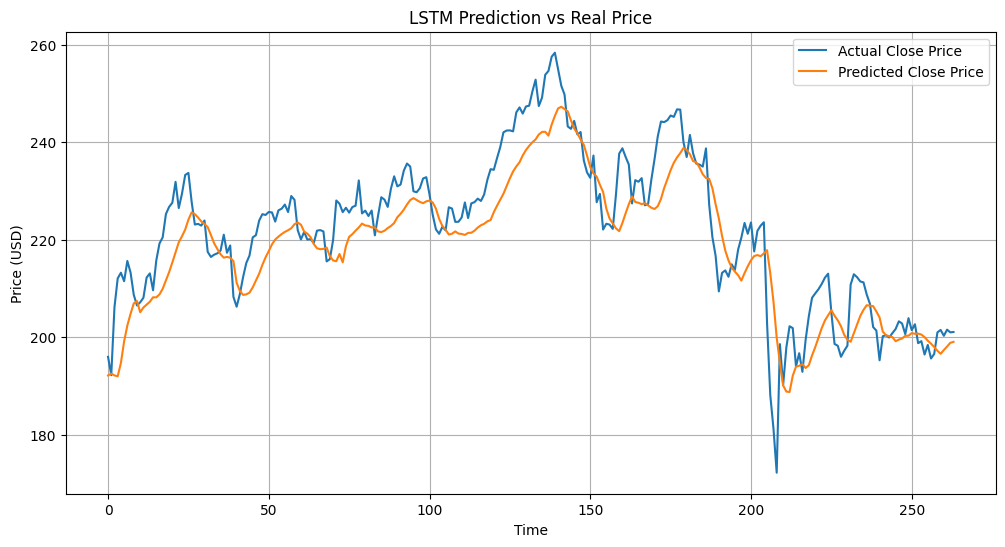

In [ ]:
# Inverse-transform y_test to real Close_price values
y_test_unscaled = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1, 1), np.zeros((len(y_test), scaled_data.shape[1] - 1))])
)[:, 0]


#Plot

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Close Price")
plt.plot(predicted_close, label="Predicted Close Price")
plt.title("LSTM Prediction vs Real Price")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()




Quality

In [ ]:
mse = mean_squared_error(y_test_unscaled, predicted_close)
mae = mean_absolute_error(y_test_unscaled, predicted_close)
r2 = r2_score(y_test_unscaled, predicted_close)

print(f"📊 MSE: {mse:.4f}")
print(f"📊 MAE: {mae:.4f}")
print(f"📈 R² score: {r2:.4f}")

📊 MSE: 58.9494
📊 MAE: 6.0426
📈 R² score: 0.7568


Error Comparison

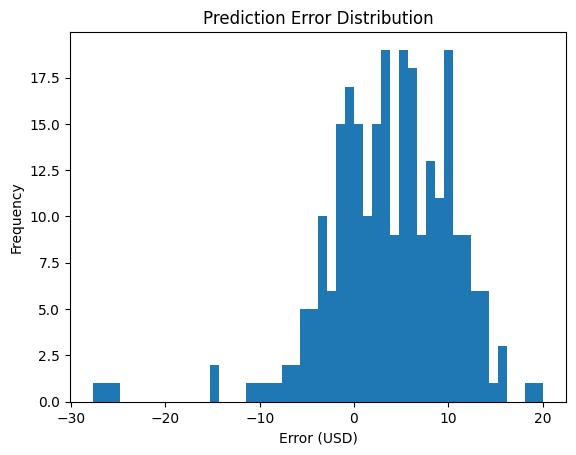

In [ ]:
errors = y_test_unscaled - predicted_close
plt.hist(errors, bins=50)
plt.title("Prediction Error Distribution")
plt.xlabel("Error (USD)")
plt.ylabel("Frequency")
plt.show()

Let's Predict the next 30 days

In [ ]:

def rolling_predict_30_days(model, appl_table, scaler, features, steps=30):
    """
    Predict 30 days ahead using a rolling forecast.
    Each prediction uses actual historical data and is validated against true Close_price
    """
    scaled_data = scaler.transform(features)

    predicted_prices = []
    actual_prices = []
    prediction_dates = []

    for i in range(steps):
        # Get rolling window from real data
        start_idx = -60 + i
        end_idx = start_idx + 60
        window = scaled_data[start_idx:end_idx]

        if window.shape[0] < 60:
            raise ValueError("Not enough data to form a 60-day window.")

        # Reshape for model
        X = np.reshape(window, (1, 60, scaled_data.shape[1]))

        # Predict next-day Close_price (scaled)
        pred_scaled = model.predict(X)[0][0]

        # Inverse transform only Close_price
        dummy = np.zeros((1, scaled_data.shape[1]))
        dummy[0, 0] = pred_scaled
        pred_price = scaler.inverse_transform(dummy)[0, 0]

        predicted_prices.append(pred_price)

        # Get actual Close_price for day i ahead
        target_idx = len(features) - 60 + i
        actual_price = appl_table["Close_price"].iloc[target_idx]
        actual_prices.append(actual_price)

        # Get corresponding date
        date = appl_table.index[target_idx]
        prediction_dates.append(date)

    return prediction_dates, predicted_prices, actual_prices


Download Yahoo Finance Test

In [ ]:
# Download from Yahoo last-30 days

def load_financial_data_30(ticker):
    """
    Load financial data for a given ticker.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        pd.DataFrame: DataFrame containing financial data.
    """
    DELTA_OUTPUT_PATH = f"./data/{ticker}_yfinance_30"
    # Fetch data from Yahoo Finance
    df = yf.download(ticker, start="2025-07-01", end="2025-07-20")
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")

    os.makedirs(DELTA_OUTPUT_PATH, exist_ok=True)
    write_deltalake(DELTA_OUTPUT_PATH, df, mode="overwrite")

    print(f"✅ Exported {len(df)} rows to {DELTA_OUTPUT_PATH}")




    # Run

    ticker = "AAPL"

    try:
        print("X")
        load_financial_data_30(ticker)
        data = DeltaTable(f"./data/{ticker}_yfinance_30")
        appl_table_30 = data.to_pandas()

        # Apply renaming function to all columns
        appl_table_30.columns = [clean_columns(col) if col != 'Date' else 'Date' for col in appl_table_30.columns]

        # Convert Date to datetime and set as index
        appl_table_30["Date"] = pd.to_datetime(appl_table_30["Date"])
        appl_table_30 = appl_table_30.set_index("Date")

        print(appl_table_30.tail())

    except ValueError as e:
        print(e)

Test

In [ ]:
dates, preds, actuals = rolling_predict_30_days(model, appl_table, scaler, features, steps=30)